# Test Algorithms 

1) Иерархическая кластеризация 
2) К — средних
3) DBSCAN
4) Разделения смеси гауссиан (EM). 


In [1]:
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import set_random_seed 
import os
import random as rn 
import pandas as pd
import pymorphy2
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

SEED = 32 
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

### Load processed texts

In [2]:
X_ = np.load('data_x.npy') 
Y_ = np.load('data_y.npy')

In [3]:
print(X_.shape)

(1906, 50)


In [4]:
print(Y_.shape)

(1906,)


### Fetch 20 news groups

dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42) 
data_test = fetch_20newsgroups(subset='test',  shuffle=True, random_state=42)
print('data loaded')

data loaded


In [5]:
y_train, y_test = data_train.target, data_test.target

In [6]:
%%time
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)

CPU times: user 6.45 s, sys: 16 ms, total: 6.46 s
Wall time: 6.47 s


In [7]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=50): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(x) 
    return x1 

In [8]:
%%time
X_train_ = encode_svd(X_train)

CPU times: user 1min 40s, sys: 1min 20s, total: 3min
Wall time: 1min 26s


In [9]:
y_train[y_train==1]
print(len(np.unique(y_train)), len(y_train))

20 11314


In [10]:
X_ = X_train_[:]
Y_ = y_train[:]

In [11]:

print(X_.shape)
print(Y_.shape)
print(np.unique(Y_))

(11314, 50)
(11314,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Берем только 10 первых классов 0-9

In [13]:
yindex = Y_[Y_ < 8]
xindex = X_[Y_ < 8]
print(len(xindex), len(yindex))
X_ = xindex
Y_ = yindex

4595 4595


### Test

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics 

def test_cluster(x,y, model):   
    model.fit(x)
    labels = model.labels_
    
    scores = []
    scores.append(metrics.homogeneity_score(y, labels))
    scores.append(metrics.completeness_score(y, labels))
    scores.append(metrics.v_measure_score(y, labels))
    scores.append(metrics.adjusted_rand_score(y, labels))
    scores.append(metrics.adjusted_mutual_info_score(y, labels,
                                               average_method='arithmetic'))
    try:
        scores.append(metrics.silhouette_score(x, labels, metric='sqeuclidean'))
    except ValueError:
        scores.append(0.0)
    scores.append(len(np.unique(labels)))
     
    print("Homogeneity: %0.3f" %  scores[0])
    print("Completeness: %0.3f" % scores[1])
    print("V-measure: %0.3f" % scores[2])
    print("Adjusted Rand Index: %0.3f"  % scores[3])
    print("Adjusted Mutual Information: %0.3f"  % scores[4])
    print("Silhouette Coefficient: %0.3f"  % scores[5])
    print("labels num: %0.3f"  % scores[6])
    return scores

### Подготавливаем массив для хранения результатов


In [8]:
results = []
n_clusters = len(np.unique(Y_))
print(n_clusters)

10


### Model KMeans

In [7]:

from sklearn.cluster import KMeans

m1 = KMeans(n_clusters=n_clusters, random_state=SEED)
r = test_cluster(X_, Y_, m1)
results.append(r)

Homogeneity: 0.158
Completeness: 0.182
V-measure: 0.169
Adjusted Rand Index: 0.045
Adjusted Mutual Information: 0.160
Silhouette Coefficient: 0.089
labels num: 10.000


### Agglomerative Clustering

In [11]:
from sklearn.cluster.hierarchical import AgglomerativeClustering
m2 = AgglomerativeClustering(n_clusters=n_clusters)
r = test_cluster(X_, Y_, m2)
results.append(r)

Homogeneity: 0.127
Completeness: 0.184
V-measure: 0.150
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.139
Silhouette Coefficient: 0.108
labels num: 10.000


### DBSCAN

In [12]:
from sklearn.cluster import DBSCAN
m3 = DBSCAN(eps=0.212, min_samples = 2)
r = test_cluster(X_, Y_, m3)
results.append(r)

Homogeneity: 0.168
Completeness: 0.186
V-measure: 0.176
Adjusted Rand Index: -0.009
Adjusted Mutual Information: 0.085
Silhouette Coefficient: -0.177
labels num: 106.000


### GaussianMixture

In [40]:
from sklearn.mixture import GaussianMixture

class GM:
    
    def __init__(self, model):
        self.model = model
        self.labels_ = []
    
    def fit(self, x):
        self.model.fit(x)
        self.labels_ = self.model.predict(x)
        
        

m4 = GaussianMixture(n_components=n_clusters)
r = test_cluster(X_, Y_,GM(m4))
results.append(r)

Homogeneity: 0.130
Completeness: 0.162
V-measure: 0.144
Adjusted Rand Index: 0.055
Adjusted Mutual Information: 0.134
Silhouette Coefficient: 0.068
labels num: 10.000


### Экспериментальный алгоритм

In [9]:

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np 

class Cluster:
    
    def __init__(self, n):
        ''' '''
        self.n = n # номер класетра (начальной точки)
        self.nodes = set([n]) # объединенные с кластером точки 
        self.join_n  = -1 # номер кластера с которым слит
        self.dist = -1 # расстояние при слиянии (dist <= 0)

    def active(self):
        ''' '''
        return self.join_n == -1
        
    def merge(self, c, dist):
        ''' '''
        self.nodes = self.nodes.union(c.nodes) 
        c.join_n = self.n
        c.dist = np.abs(dist)
        
    def get_n(self):
        ''' '''
        if self.join_n == -1:
            return self.n
        return self.join_n
        
class HierarchicalClustering:
    
    def __init__(self, alpha = 1.01, max_iteration = 200, debug= False, delta=0., stop_neg_sum = True, betta = 2.,n_clusters=1):
        ''' '''
        self.alpha = alpha
        self.betta = betta
        self.max_iteration = max_iteration
        self.debug = debug
        self._c_all = []
        self.delta = delta
        self.stop_neg_sum = stop_neg_sum
        self.n_clusters= n_clusters
        self.labels_ = []
            
    
    def fit(self, x):
        ''' '''
        self._c_all = []
        y_ = []
        M =  euclidean_distances(x,x)
        C = []
        size = len(M)
        for i in range(size): 
            C.append( Cluster(i) )
        
        delta = self.delta
        
        for i in range(self.max_iteration): 
            d = np.min(M[M > 0])  
            #d = self._get_min(M, C) * self.alpha
            if d > delta:
                delta = d  
            delta = delta * self.alpha    
            if(self.debug):   
                print('delta: %.3f, d: %.3f' % (delta, d))    
            M_ = M - delta
            ''' join clusters '''
            join = False
        
            for i in range(size):  
                for j in range(i+1,size):  
                    
                    if(M[i][j] <= 0 or M_[i][j] > 0):
                        continue 
                        
                    if C[i].dist > np.abs(M_[i][j]): 
                        continue
                        
                    a = C[i].get_n()
                    b = C[j].get_n() 
                    if(a == b):
                        continue 
            
                    C[a].merge(C[b], M_[i][j]) 
                    for s in C[b].nodes:
                        #C[s].join_n = a
                        C[a].merge(C[s], M_[i][j])
                    join = True        
            if join == False: 
                delta = delta * self.betta 
                continue
            
            M =   M_ 
                    
            if len(M[M > 0]) == 0:
                break
               
            y_ = np.zeros(size)
            cl = 0
            for c in C:
                if(c.active() == True): 
                    for i in c.nodes:
                        y_[i] = cl
                    cl = cl + 1
                    
            self._c_all.append(y_)  
          
            if len(np.unique(y_)) <= self.n_clusters: 
                break
            neg,pos = [],[]    
            for i in range(size): 
                for j in range(i,size):
                    if C[i].active() == False:
                        continue
                    if C[j].active() == False:
                        continue
                        
                    if(M[i][j] <= 0):
                        neg.append(np.abs(M[i][j]) + delta)
                    elif(M[i][j] > 0):
                        pos.append(M[i][j])    
            if(self.debug):
                print('Sum pos: %.3f, sum neg: %.3f, Std pos: %.3f, Std neg: %.3f' % 
                      (sum(pos) , sum(neg) ,np.std(pos), np.std(neg))) 
            if np.std(pos) == 0:
                break
            if self.stop_neg_sum and sum(pos) / len(pos) < sum(neg) / len(neg): 
                print('sum(pos) < sum(neg)')
                break 
        self.labels_ = y_         
        return y_                
        
    def print_name(self):
        print('Hierarchical clustering')
        


In [10]:
m5 = HierarchicalClustering(alpha=1,n_clusters=n_clusters,stop_neg_sum=False)
r = test_cluster(X_, Y_, m5)
results.append(r) 

Homogeneity: 0.009
Completeness: 0.210
V-measure: 0.017
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.006
Silhouette Coefficient: 0.223
labels num: 8.000


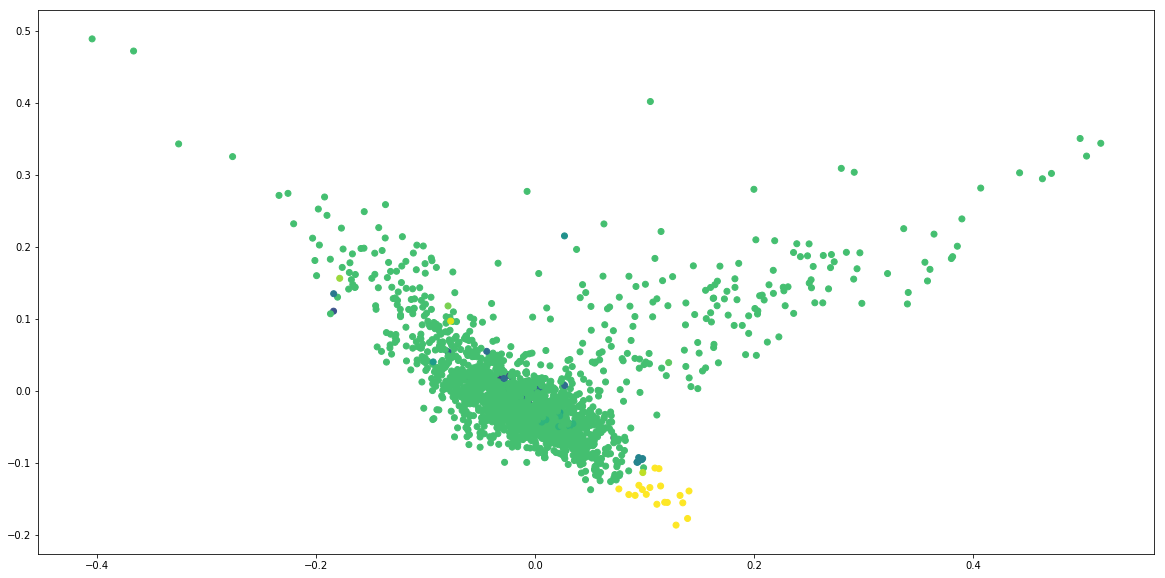

In [11]:
from sklearn.decomposition import PCA, SparsePCA, NMF

p = PCA(n_components=2)
x1 = p.fit_transform(X_)


plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x1[:,0], x1[:,1], c=m5._c_all[-2])

In [26]:
r

array([14., 14., 14., ..., 14., 14., 14.])

In [12]:
df = pd.read_pickle('data/dftime_cat.pkl')

In [34]:
r = np.array(m5._c_all[-4])
u = np.unique(r)

for i in u:
    indexs = np.where(r == i)[0]
    print('Cluster: %d, len: %d' % (i, len(indexs)))
    for n in indexs[0:3]:
        t,d = df.iloc[n]['title'],  df.iloc[n]['text2']
        print('N: %d, title: %s' % (n, t))
    print()    
        
        #print(df['title'][n])
 

Cluster: 0, len: 2
N: 0, title: россия удивлена заявлениями премьер-министра украины и хочет разъяснений
N: 431, title: украина вступает в вто

Cluster: 1, len: 8
N: 11, title: тайные операции цру в европе
N: 13, title: первый визит штайнмайера в сша
N: 21, title: высказывание кондолизы райс о тайных операциях цру в европе

Cluster: 2, len: 1
N: 24, title: кондолиза райс успокоила европу

Cluster: 3, len: 1
N: 29, title: парламентские выборы в ираке

Cluster: 4, len: 1
N: 36, title: в иране запрещают «неприличную» музыку

Cluster: 5, len: 1
N: 49, title: цены на газ

Cluster: 6, len: 2
N: 84, title: большая пресс-конференция президента россии
N: 1869, title: большая пресс-конференция владимира путина 2014 года

Cluster: 7, len: 1
N: 106, title: единый день голосования 12 марта 2006

Cluster: 8, len: 2
N: 113, title: последний прогноз выборов на украине
N: 115, title: предварительный итог выборов на украине

Cluster: 9, len: 1
N: 125, title: возможно, махмуд ахмадинежад прибудет в герма

### Таблица результатов

In [12]:
df2 = pd.DataFrame(results, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
df2.head(len(results))

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information,Silhouette Coefficient,len
0,0.158236,0.182376,0.169450,0.044860,0.160114,0.088911,10
1,0.127000,0.184168,0.150333,0.011810,0.139469,0.108352,10
2,0.035664,0.245722,0.062288,-0.002691,0.017989,-0.466628,33
3,0.175493,0.186219,0.180697,0.073454,0.171884,0.031663,10
4,0.008606,0.210222,0.016535,-0.002967,0.006019,0.222945,8


In [15]:
from scipy.stats import ttest_ind
#from scipy.stats import 

?scipy.stats.t.ppf

Object `scipy.stats.t.ppf` not found.


In [16]:
np.round(df2.values, 2)

NameError: name 'df2' is not defined

### Тест 2

Сравним 4 алгоритма на синтетических наборах данных

- HierarchicalClustering и DBSCAN как адаптивные алгоритмы

- HierarchicalClustering и AgglomerativeClustering как аглоритмически близкие

In [46]:
from sklearn  import datasets
 
#dx, dy    
def test_2algo(func_ds, test_alg):
    result1,result2 = [],[] 

    for n in range(100): 
        bx,by = func_ds()
        n_clusters = len(np.unique(by))
        print(n_clusters)
        
        m5 = HierarchicalClustering(alpha=1,n_clusters=n_clusters,debug=0)
        r = test_cluster(bx, by, m5)
        result1.append(r) 

        m3 = test_alg #DBSCAN(min_samples = 2) #DBSCAN(eps=0.103, min_samples = 2)
        r = test_cluster(bx, by, m3)
        result2.append(r)

    df2_1 = pd.DataFrame(result1, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
    df2_2 = pd.DataFrame(result2, columns=[ 
    'Homogeneity', 
    'Completeness', 
    'V-measure', 
    'Adjusted Rand Index', 'Adjusted Mutual Information', 'Silhouette Coefficient', 'len'])
    
    ###
    # 200 - 2 = 198 => 180-199	1.973 # http://medstatistic.ru/theory/t_cryteria.html
    # http://medstatistic.ru/theory/t_cryteria.html
    ss = 1.973
    df2_1.replace([np.inf, -np.inf], np.nan)
    df2_2.replace([np.inf, -np.inf], np.nan)
    df2_1.fillna(0)
    df2_2.fillna(0)
    for c in df2_1.columns:
        
        # print(df2_1[c].values)
        # print(df2_2[c].values)
        tStat = ttest_ind(df2_1[c].values, df2_2[c].values)
        z = "<"
        if df2_1[c].mean() > df2_2[c].mean():
            z = ">"
        print('%s: important: %s, alg1: %.4f, alg2: %.4f %s %.4f' % (c, np.abs(tStat.statistic) > ss, tStat.statistic, df2_1[c].mean(), z, df2_2[c].mean()))


In [53]:
 

?datasets.make_circles

####  2 класса

- make_blobs
- moons

### DBSCAN VS test

In [54]:
 
def ds2():
    return datasets.make_blobs(n_samples=100,  n_features=3, cluster_std=1 + np.random.rand())
 
def ds2moon():
    return datasets.make_moons(n_samples=100,   noise=.05)

# dep
def ds2b2():
    return datasets.make_blobs(n_samples=100,cluster_std=[1.0, 2.5, 0.5],random_state=60)

def ds2circl():
    return datasets.make_circles(n_samples=100, factor=.5, noise=.05, random_state=np.random.randint(1,255))

def ds2len(): 
    X, y = datasets.make_blobs(n_samples=100, random_state=np.random.randint(1,255))
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    x = np.dot(X, transformation)
    return x,y


test_2algo(ds2, DBSCAN(eps=0.212, min_samples = 2))

3
Homogeneity: 0.496
Completeness: 0.802
V-measure: 0.613
Adjusted Rand Index: 0.498
Adjusted Mutual Information: 0.603
Silhouette Coefficient: 0.538
labels num: 3.000
Homogeneity: 0.020
Completeness: 0.224
V-measure: 0.037
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.016
Silhouette Coefficient: -0.193
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.914
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 1.000
V-measure: 0.737
Adjusted Rand Index: 0.574
Adjusted Mutual Information: 0.734
Silhouette Coefficient: 0.927
labels num: 2.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.400
labels num: 2.

Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.684
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.589
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.838
labels num: 3.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.366
labels num: 2.000

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.893
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 0.935
V-measure: 0.719
Adjusted Rand Index: 0.560
Adjusted Mutual Information: 0.712
Silhouette Coefficient: 0.108
labels num: 3.000
Homogeneity: 0.021
Completeness: 0.230
V-measure: 0.038
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.017
Silhouette Coefficient: 0.019
labels num: 2.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.953
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000


Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.957
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.030
Completeness: 0.216
V-measure: 0.053
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.016
Silhouette Coefficient: -0.088
labels num: 3.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.551
labels num: 3.0

In [17]:
test_2algo(ds2moon, DBSCAN(eps=0.212, min_samples = 2)) 

2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.382
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.382
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.375
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.375
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.386
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.386
labels num: 2.00

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.383
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.383
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.386
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.518
V-measure: 0.682
Adjusted Rand Index: 0.540
Adjusted Mutual Information: 0.677
Silhouette Coefficient: 0.514
labels num: 4.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.934
V-measure: 0.966
Adjusted Rand Index: 0.980
Adjusted Mutual Information: 0.965
Silhouette Coefficient: -0.180
labels num: 3.

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.385
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.676
V-measure: 0.807
Adjusted Rand Index: 0.761
Adjusted Mutual Information: 0.804
Silhouette Coefficient: 0.391
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.389
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.389
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000


Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.384
labels num: 2.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.384
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.700
V-measure: 0.824
Adjusted Rand Index: 0.796
Adjusted Mutual Information: 0.822
Silhouette Coefficient: 0.190
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.676
V-measure: 0.807
Adjusted Rand Index: 0.761
Adjusted Mutual Information: 0.804
Silhouette Coefficient: 0.388
labels num: 3.000


In [55]:
#test_2algo(ds2b2, DBSCAN(eps=0.212, min_samples = 2)) 

In [51]:
test_2algo(ds2circl, DBSCAN(eps=0.212, min_samples = 2)) 

2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.101
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.430
V-measure: 0.601
Adjusted Rand Index: 0.580
Adjusted Mutual Information: 0.587
Silhouette Coefficient: -0.014
labels num: 8.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.471
V-measure: 0.640
Adjusted Rand Index: 0.604
Adjusted Mutual Information: 0.631
Silhouette Coefficient: 0.174
labels num: 6.000
2
Homogeneity: 0.296
Completeness: 0.372
V-measure: 0.329
Adjusted Rand Index: 0.225
Adjusted Mutual Information: 0.324
Silhouette Coefficient: 0.337
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.547
V-measure: 0.708
Adjusted Rand Index: 0.673
Adjusted Mutual Information: 0.701
Silhouette Coefficient: -0.016
labels num:

Homogeneity: 0.031
Completeness: 0.158
V-measure: 0.051
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.036
Silhouette Coefficient: 0.124
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.403
V-measure: 0.574
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.555
Silhouette Coefficient: 0.040
labels num: 10.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.099
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.372
V-measure: 0.542
Adjusted Rand Index: 0.354
Adjusted Mutual Information: 0.525
Silhouette Coefficient: 0.123
labels num: 9.000
2
Homogeneity: 0.144
Completeness: 0.258
V-measure: 0.185
Adjusted Rand Index: 0.063
Adjusted Mutual Information: 0.177
Silhouette Coefficient: 0.290
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.440
V-measure: 0.611
Adjusted Rand Index: 0.592
Adjusted Mutual Information: 0.596
Silhouette Coefficient: 0.097
labels num: 8.000

Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.493
V-measure: 0.660
Adjusted Rand Index: 0.645
Adjusted Mutual Information: 0.648
Silhouette Coefficient: -0.110
labels num: 7.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.460
V-measure: 0.630
Adjusted Rand Index: 0.601
Adjusted Mutual Information: 0.618
Silhouette Coefficient: 0.124
labels num: 7.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.098
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.404
V-measure: 0.576
Adjusted Rand Index: 0.568
Adjusted Mutual Information: 0.556
Silhouette Coefficient: 0.041
labels num:

Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.442
V-measure: 0.613
Adjusted Rand Index: 0.594
Adjusted Mutual Information: 0.598
Silhouette Coefficient: 0.128
labels num: 8.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.103
labels num: 2.000
Homogeneity: 1.000
Completeness: 0.394
V-measure: 0.565
Adjusted Rand Index: 0.567
Adjusted Mutual Information: 0.539
Silhouette Coefficient: -0.040
labels num: 12.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 1.000
Completeness: 0.431
V-measure: 0.602
Adjusted Rand Index: 0.583
Adjusted Mutual Information: 0.588
Silhouette Coefficient: 0.058
labels num

In [57]:
test_2algo(ds2len, DBSCAN(eps=0.212, min_samples = 2))  

3
Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.840
labels num: 3.000
Homogeneity: 0.708
Completeness: 0.313
V-measure: 0.434
Adjusted Rand Index: 0.141
Adjusted Mutual Information: 0.347
Silhouette Coefficient: 0.234
labels num: 20.000
3
Homogeneity: 0.478
Completeness: 0.739
V-measure: 0.581
Adjusted Rand Index: 0.487
Adjusted Mutual Information: 0.571
Silhouette Coefficient: 0.606
labels num: 3.000
Homogeneity: 0.699
Completeness: 0.350
V-measure: 0.466
Adjusted Rand Index: 0.184
Adjusted Mutual Information: 0.415
Silhouette Coefficient: 0.225
labels num: 13.000
3
Homogeneity: 0.918
Completeness: 0.918
V-measure: 0.918
Adjusted Rand Index: 0.941
Adjusted Mutual Information: 0.917
Silhouette Coefficient: 0.901
labels num: 3.000
Homogeneity: 0.584
Completeness: 0.275
V-measure: 0.374
Adjusted Rand Index: 0.054
Adjusted Mutual Information: 0.271
Silhouette Coefficient: 0.097
labels num: 20

Homogeneity: 0.584
Completeness: 0.894
V-measure: 0.706
Adjusted Rand Index: 0.545
Adjusted Mutual Information: 0.698
Silhouette Coefficient: 0.844
labels num: 3.000
Homogeneity: 0.490
Completeness: 0.249
V-measure: 0.330
Adjusted Rand Index: 0.125
Adjusted Mutual Information: 0.277
Silhouette Coefficient: 0.297
labels num: 11.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.962
labels num: 3.000
Homogeneity: 0.739
Completeness: 0.295
V-measure: 0.422
Adjusted Rand Index: 0.090
Adjusted Mutual Information: 0.324
Silhouette Coefficient: 0.298
labels num: 23.000
3
Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.827
labels num: 3.000
Homogeneity: 0.548
Completeness: 0.247
V-measure: 0.341
Adjusted Rand Index: 0.065
Adjusted Mutual Information: 0.244
Silhouette Coefficient: 0.245
labels num: 19.0

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.810
labels num: 3.000
Homogeneity: 0.695
Completeness: 0.306
V-measure: 0.425
Adjusted Rand Index: 0.113
Adjusted Mutual Information: 0.342
Silhouette Coefficient: 0.190
labels num: 19.000
3
Homogeneity: 0.577
Completeness: 1.000
V-measure: 0.732
Adjusted Rand Index: 0.563
Adjusted Mutual Information: 0.729
Silhouette Coefficient: 0.921
labels num: 2.000
Homogeneity: 0.750
Completeness: 0.293
V-measure: 0.421
Adjusted Rand Index: 0.088
Adjusted Mutual Information: 0.320
Silhouette Coefficient: 0.317
labels num: 24.000
3
Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.827
labels num: 3.000
Homogeneity: 0.548
Completeness: 0.247
V-measure: 0.341
Adjusted Rand Index: 0.065
Adjusted Mutual Information: 0.244
Silhouette Coefficient: 0.245
labels num: 19.0

Homogeneity: 0.959
Completeness: 0.959
V-measure: 0.959
Adjusted Rand Index: 0.970
Adjusted Mutual Information: 0.958
Silhouette Coefficient: 0.721
labels num: 3.000
Homogeneity: 0.761
Completeness: 0.329
V-measure: 0.460
Adjusted Rand Index: 0.168
Adjusted Mutual Information: 0.384
Silhouette Coefficient: 0.277
labels num: 19.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.712
labels num: 3.000
Homogeneity: 0.521
Completeness: 0.261
V-measure: 0.348
Adjusted Rand Index: 0.133
Adjusted Mutual Information: 0.277
Silhouette Coefficient: 0.247
labels num: 14.000
3
Homogeneity: 0.584
Completeness: 0.935
V-measure: 0.719
Adjusted Rand Index: 0.560
Adjusted Mutual Information: 0.712
Silhouette Coefficient: 0.714
labels num: 3.000
Homogeneity: 0.677
Completeness: 0.308
V-measure: 0.424
Adjusted Rand Index: 0.116
Adjusted Mutual Information: 0.350
Silhouette Coefficient: 0.132
labels num: 17.0

### Test vs AgglomerativeClustering

In [24]:
_,yy = ds2()
np.unique(yy)

array([0, 1, 2])

In [58]:
test_2algo(ds2, AgglomerativeClustering(n_clusters = 3))

3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.939
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.939
labels num: 3.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.840
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.840
labels num: 3.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.475
labels num: 3.000
Homogeneity: 0.959
Completeness: 0.959
V-measure: 0.959
Adjusted Rand Index: 0.970
Adjusted Mutual Information: 0.958
Silhouette Coefficient: 0.797
labels num: 3.00

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.930
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.930
labels num: 3.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.923
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.923
labels num: 3.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.943
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.943
labels num: 3.000


Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.780
labels num: 3.000
Homogeneity: 0.587
Completeness: 0.621
V-measure: 0.603
Adjusted Rand Index: 0.519
Adjusted Mutual Information: 0.596
Silhouette Coefficient: 0.546
labels num: 3.000
3
Homogeneity: 0.543
Completeness: 0.869
V-measure: 0.669
Adjusted Rand Index: 0.535
Adjusted Mutual Information: 0.660
Silhouette Coefficient: 0.520
labels num: 3.000
Homogeneity: 0.885
Completeness: 0.888
V-measure: 0.886
Adjusted Rand Index: 0.884
Adjusted Mutual Information: 0.884
Silhouette Coefficient: 0.694
labels num: 3.000
3
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.904
labels num: 3.000
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.904
labels num: 3.000


Homogeneity: 0.577
Completeness: 0.934
V-measure: 0.714
Adjusted Rand Index: 0.548
Adjusted Mutual Information: 0.707
Silhouette Coefficient: 0.717
labels num: 3.000
Homogeneity: 0.580
Completeness: 0.671
V-measure: 0.622
Adjusted Rand Index: 0.523
Adjusted Mutual Information: 0.614
Silhouette Coefficient: 0.516
labels num: 3.000
3
Homogeneity: 0.584
Completeness: 0.934
V-measure: 0.718
Adjusted Rand Index: 0.559
Adjusted Mutual Information: 0.711
Silhouette Coefficient: 0.703
labels num: 3.000
Homogeneity: 0.664
Completeness: 0.705
V-measure: 0.684
Adjusted Rand Index: 0.608
Adjusted Mutual Information: 0.678
Silhouette Coefficient: 0.563
labels num: 3.000
3
Homogeneity: 0.590
Completeness: 0.935
V-measure: 0.724
Adjusted Rand Index: 0.570
Adjusted Mutual Information: 0.717
Silhouette Coefficient: 0.452
labels num: 3.000
Homogeneity: 0.918
Completeness: 0.918
V-measure: 0.918
Adjusted Rand Index: 0.941
Adjusted Mutual Information: 0.917
Silhouette Coefficient: 0.756
labels num: 3.000


In [59]:
_,yy = ds2moon()
np.unique(yy)

array([0, 1])

In [60]:
test_2algo(ds2moon, AgglomerativeClustering(n_clusters = 2))

2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.382
labels num: 2.000
Homogeneity: 0.515
Completeness: 0.546
V-measure: 0.530
Adjusted Rand Index: 0.514
Adjusted Mutual Information: 0.527
Silhouette Coefficient: 0.570
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 0.433
Completeness: 0.479
V-measure: 0.455
Adjusted Rand Index: 0.404
Adjusted Mutual Information: 0.451
Silhouette Coefficient: 0.580
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.385
labels num: 2.000
Homogeneity: 0.396
Completeness: 0.449
V-measure: 0.421
Adjusted Rand Index: 0.355
Adjusted Mutual Information: 0.416
Silhouette Coefficient: 0.577
labels num: 2.00

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.377
labels num: 2.000
Homogeneity: 0.453
Completeness: 0.495
V-measure: 0.473
Adjusted Rand Index: 0.431
Adjusted Mutual Information: 0.469
Silhouette Coefficient: 0.581
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.381
labels num: 2.000
Homogeneity: 0.100
Completeness: 0.103
V-measure: 0.102
Adjusted Rand Index: 0.121
Adjusted Mutual Information: 0.095
Silhouette Coefficient: 0.622
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.377
labels num: 2.000
Homogeneity: 0.414
Completeness: 0.464
V-measure: 0.438
Adjusted Rand Index: 0.379
Adjusted Mutual Information: 0.433
Silhouette Coefficient: 0.572
labels num: 2.000


Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 0.361
Completeness: 0.422
V-measure: 0.389
Adjusted Rand Index: 0.308
Adjusted Mutual Information: 0.384
Silhouette Coefficient: 0.565
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.387
labels num: 2.000
Homogeneity: 0.473
Completeness: 0.511
V-measure: 0.491
Adjusted Rand Index: 0.457
Adjusted Mutual Information: 0.487
Silhouette Coefficient: 0.591
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.391
labels num: 2.000
Homogeneity: 0.232
Completeness: 0.238
V-measure: 0.235
Adjusted Rand Index: 0.285
Adjusted Mutual Information: 0.229
Silhouette Coefficient: 0.636
labels num: 2.000


Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.393
labels num: 2.000
Homogeneity: 0.473
Completeness: 0.511
V-measure: 0.491
Adjusted Rand Index: 0.457
Adjusted Mutual Information: 0.487
Silhouette Coefficient: 0.575
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.389
labels num: 2.000
Homogeneity: 0.245
Completeness: 0.247
V-measure: 0.246
Adjusted Rand Index: 0.307
Adjusted Mutual Information: 0.240
Silhouette Coefficient: 0.652
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.376
labels num: 2.000
Homogeneity: 0.585
Completeness: 0.606
V-measure: 0.595
Adjusted Rand Index: 0.605
Adjusted Mutual Information: 0.592
Silhouette Coefficient: 0.549
labels num: 2.000


In [30]:
_,yy = ds2b2()
np.unique(yy)

array([0, 1, 2])

In [56]:
#test_2algo(ds2b2, AgglomerativeClustering(n_clusters = 3))

In [61]:
_,yy = ds2circl()
np.unique(yy)

array([0, 1])

In [62]:
test_2algo(ds2circl, AgglomerativeClustering(n_clusters = 2))

2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.102
labels num: 2.000
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Index: -0.008
Adjusted Mutual Information: -0.006
Silhouette Coefficient: 0.437
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.101
labels num: 2.000
Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand Index: -0.004
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.488
labels num: 2.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.003
Completeness: 0.003
V-measure: 0.003
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.434
labels 

Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.010
Adjusted Mutual Information: -0.007
Silhouette Coefficient: 0.479
labels num: 2.000
2
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.833
V-measure: 0.909
Adjusted Rand Index: 0.926
Adjusted Mutual Information: 0.907
Silhouette Coefficient: -0.051
labels num: 3.000
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.010
Adjusted Mutual Information: -0.007
Silhouette Coefficient: 0.484
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.099
labels num: 2.000
Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand Index: -0.004
Adjusted Mutual Information: -0.003
Silhouette Coeffic

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.101
labels num: 2.000
Homogeneity: 0.003
Completeness: 0.003
V-measure: 0.003
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.411
labels num: 2.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.003
Completeness: 0.003
V-measure: 0.003
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.457
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.105
labels num: 2.000
Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.462
labels nu

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.098
labels num: 2.000
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.010
Adjusted Mutual Information: -0.007
Silhouette Coefficient: 0.493
labels num: 2.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.011
Completeness: 0.011
V-measure: 0.011
Adjusted Rand Index: 0.005
Adjusted Mutual Information: 0.004
Silhouette Coefficient: 0.418
labels num: 2.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.102
labels num: 2.000
Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.457
labels num:

In [34]:
_,yy = ds2len()
np.unique(yy)

array([0, 1, 2])

In [63]:
test_2algo(ds2circl, AgglomerativeClustering(n_clusters = 3))

2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.097
labels num: 2.000
Homogeneity: 0.011
Completeness: 0.007
V-measure: 0.009
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.003
Silhouette Coefficient: 0.492
labels num: 3.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.009
Completeness: 0.006
V-measure: 0.007
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.521
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.098
labels num: 2.000
Homogeneity: 0.012
Completeness: 0.008
V-measure: 0.009
Adjusted Rand Index: -0.002
Adjusted Mutual Information: -0.002
Silhouette Coefficient: 0.505
labels 

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.105
labels num: 2.000
Homogeneity: 0.025
Completeness: 0.016
V-measure: 0.020
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.008
Silhouette Coefficient: 0.458
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.105
labels num: 2.000
Homogeneity: 0.010
Completeness: 0.007
V-measure: 0.008
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.004
Silhouette Coefficient: 0.452
labels num: 3.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand Index: -0.012
Adjusted Mutual Information: -0.011
Silhouette Coefficient: 0.529
labels num:

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.100
labels num: 2.000
Homogeneity: 0.017
Completeness: 0.011
V-measure: 0.014
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.466
labels num: 3.000
2
Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: 0.012
Completeness: 0.008
V-measure: 0.010
Adjusted Rand Index: -0.003
Adjusted Mutual Information: -0.002
Silhouette Coefficient: 0.522
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.095
labels num: 2.000
Homogeneity: 0.010
Completeness: 0.007
V-measure: 0.008
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.004
Silhouette Coefficient: 0.499
labels num:

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.107
labels num: 2.000
Homogeneity: 0.003
Completeness: 0.002
V-measure: 0.002
Adjusted Rand Index: -0.011
Adjusted Mutual Information: -0.009
Silhouette Coefficient: 0.536
labels num: 3.000
2
Homogeneity: 0.144
Completeness: 0.258
V-measure: 0.185
Adjusted Rand Index: 0.063
Adjusted Mutual Information: 0.177
Silhouette Coefficient: 0.273
labels num: 2.000
Homogeneity: 0.008
Completeness: 0.005
V-measure: 0.006
Adjusted Rand Index: -0.007
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.502
labels num: 3.000
2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.107
labels num: 2.000
Homogeneity: 0.008
Completeness: 0.005
V-measure: 0.007
Adjusted Rand Index: -0.006
Adjusted Mutual Information: -0.005
Silhouette Coefficient: 0.481
labels num: 

#### 10 класса


In [49]:
def ds10():
    return datasets.make_classification(n_classes=10, n_informative=10)

test_2algo(ds10, DBSCAN(eps=0.212, min_samples = 2))

10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.005
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.006
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.332
Completeness: 0.444
V-measure: 0.380
Adjusted Rand Index: 0.009
Adjusted Mutual Information: 0.020
Silhouette Coefficient: -0.278
labels num: 32.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mut

Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.012
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.246
Completeness: 0.412
V-measure: 0.308
Adjusted Rand Index: 0.001
Adjusted Mutual Information: -0.002
Silhouette Coefficient: -0.206
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.500
V-measure: 0.667
Adjusted Rand Index: 0.004
Adjusted Mut

sum(pos) < sum(neg)
Homogeneity: 0.215
Completeness: 0.427
V-measure: 0.286
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.016
Silhouette Coefficient: -0.238
labels num: 20.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.248
Completeness: 0.426
V-measure: 0.314
Adjusted Rand Index: -0.001
Adjusted Mutual Information: 0.008
Silhouette Coefficient: -0.182
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutu

Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.010
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.249
Completeness: 0.428
V-measure: 0.315
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.009
Silhouette Coefficient: -0.290
labels num: 24.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 1.000
Completeness: 0.501
V-measure: 0.668
Adjusted Rand Index: 0.004
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.006
labels num: 99.000
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.000
labels num: 1.000
Homogeneity: important: True, alg1: 25.5204, alg2: 0.8206 > 0.0000
Completeness: important: True, alg1: -162.8476, alg2: 0.4822 < 1.0000
V-measure: important: True, alg1: 35.7442, alg2: 0.5794 > 0.0000
Adjusted Rand Index: important: True, alg1: 4.8142, alg2: 0.0017 > 0.0000
Adjusted Mutual Information: im

In [50]:
test_2algo(ds10, AgglomerativeClustering(n_clusters = 10))

10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.004
labels num: 99.000
Homogeneity: 0.263
Completeness: 0.291
V-measure: 0.276
Adjusted Rand Index: 0.036
Adjusted Mutual Information: 0.089
Silhouette Coefficient: 0.181
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.663
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.006
labels num: 99.000
Homogeneity: 0.304
Completeness: 0.330
V-measure: 0.317
Adjusted Rand Index: 0.086
Adjusted Mutual Information: 0.141
Silhouette Coefficient: 0.166
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.003
labels num: 99.000
Homogeneity: 0.264
Completeness: 0.302
V-measure: 0.282
Adjusted Rand Index: 0.042
Adjuste

Homogeneity: 0.336
Completeness: 0.357
V-measure: 0.346
Adjusted Rand Index: 0.079
Adjusted Mutual Information: 0.175
Silhouette Coefficient: 0.130
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.429
Completeness: 0.430
V-measure: 0.430
Adjusted Rand Index: -0.002
Adjusted Mutual Information: 0.017
Silhouette Coefficient: -0.113
labels num: 39.000
Homogeneity: 0.261
Completeness: 0.281
V-measure: 0.271
Adjusted Rand Index: 0.037
Adjusted Mutual Information: 0.078
Silhouette Coefficient: 0.139
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.357
Completeness: 0.417
V-measure: 0.385
Adjusted Rand Index: -0.005
Adjusted Mutual Information: -0.003
Silhouette Coefficient: -0.197
labels num: 34.000
Homogeneity: 0.289
Completeness: 0.306
V-measure: 0.297
Adjusted Rand Index: 0.053
Adjusted Mutual Information: 0.112
Silhouette Coefficient: 0.175
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjuste

sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.011
labels num: 99.000
Homogeneity: 0.290
Completeness: 0.296
V-measure: 0.293
Adjusted Rand Index: 0.049
Adjusted Mutual Information: 0.101
Silhouette Coefficient: 0.161
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.009
labels num: 99.000
Homogeneity: 0.276
Completeness: 0.294
V-measure: 0.285
Adjusted Rand Index: 0.047
Adjusted Mutual Information: 0.099
Silhouette Coefficient: 0.163
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.129
Completeness: 0.397
V-measure: 0.194
Adjusted Rand Index: -0.002
Adjusted Mutual Information: -0.006
Silhouette Coefficient: -0.161
labels num: 13.000
Homogeneity: 0.290
Completeness: 0.320
V-measure: 0.305
Adjusted Rand Index: 0.071
Adjusted 

sum(pos) < sum(neg)
Homogeneity: 0.133
Completeness: 0.432
V-measure: 0.203
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.010
Silhouette Coefficient: -0.086
labels num: 13.000
Homogeneity: 0.291
Completeness: 0.314
V-measure: 0.302
Adjusted Rand Index: 0.060
Adjusted Mutual Information: 0.127
Silhouette Coefficient: 0.160
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.254
Completeness: 0.284
V-measure: 0.268
Adjusted Rand Index: 0.034
Adjusted Mutual Information: 0.085
Silhouette Coefficient: 0.177
labels num: 10.000
10
sum(pos) < sum(neg)
Homogeneity: 0.332
Completeness: 0.413
V-measure: 0.368
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.016
Silhouette Coefficient: -0.150
labels num: 30.000
Homogeneity: 0.306
Completeness: 0.325
V-measure: 0.315
Adjusted Rand Index: 0.093
Adjusted Mut

sum(pos) < sum(neg)
Homogeneity: 0.994
Completeness: 0.498
V-measure: 0.664
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.001
Silhouette Coefficient: 0.007
labels num: 99.000
Homogeneity: 0.285
Completeness: 0.300
V-measure: 0.292
Adjusted Rand Index: 0.050
Adjusted Mutual Information: 0.104
Silhouette Coefficient: 0.133
labels num: 10.000
Homogeneity: important: True, alg1: 14.6037, alg2: 0.7853 > 0.2775
Completeness: important: True, alg1: 38.9236, alg2: 0.4791 > 0.2966
V-measure: important: True, alg1: 15.5259, alg2: 0.5614 > 0.2867
Adjusted Rand Index: important: True, alg1: -20.3995, alg2: 0.0013 < 0.0477
Adjusted Mutual Information: important: True, alg1: -22.8522, alg2: 0.0057 < 0.1002
Silhouette Coefficient: important: True, alg1: -22.5680, alg2: -0.0428 < 0.1619
len: important: True, alg1: 19.4335, alg2: 77.6700 > 10.0000


In [69]:
#print(result3)